## Introduction

## Jupyter Notebook Setup

In [1]:
import pandas as pd
import numpy as np
import en_core_web_sm
from collections import Counter
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import compute_class_weight
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.metrics import classification_report
import warnings

In [2]:
tf.random.set_seed(9)
np.random.seed(9)
warnings.filterwarnings('ignore')
nlp = en_core_web_sm.load()

In [3]:
# Plotly renderer setup
'''
Change the default plotly renderer to colab 
because plotly's plot doesn't render on the 
internet outside of certain Python environments.
Use iframe if rendering in localhost.
'''
import plotly.io as pio
pio.renderers.default = 'iframe' # for localhost
# pio.renderers.default = 'colab' # before git commit
# Rerun all cells with plotly plots after running this cell (before git commit).

## Reading The Data

In [4]:
df = pd.read_parquet('../scraped_data/reviews.parquet.gzip')
df.head()

,title,date,location,rating,text
0,"Which iPhone you should Purchase ? iPhone 8, X...",2018-12-12,India,3.0,NOTE:@ This is detailed comparison between iPh...
1,Don't buy iPhone xr from Amazon.,2018-11-17,India,1.0,Very bad experience with this iPhone xr phone....
2,Happy with the purchase,2019-01-27,India,5.0,Amazing phone with amazing camera coming from ...
3,Amazon is not an apple authorised reseller. Pl...,2019-05-02,India,1.0,So I got the iPhone XR just today. The product...
4,Excellent Battery life and buttery smooth UI,2019-05-24,India,5.0,I've been an android user all my life until I ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3870 entries, 0 to 3869
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     3870 non-null   object        
 1   date      3870 non-null   datetime64[ns]
 2   location  3870 non-null   object        
 3   rating    3870 non-null   float32       
 4   text      3870 non-null   object        
dtypes: datetime64[ns](1), float32(1), object(3)
memory usage: 136.2+ KB


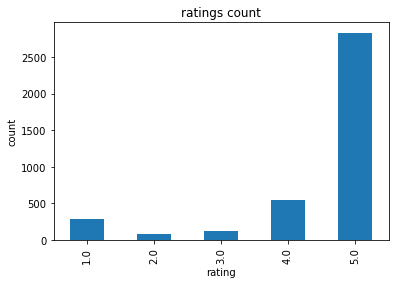

In [6]:
df['rating'].value_counts().sort_index().plot.bar(xlabel='rating', ylabel='count', title='ratings count')
plt.show()

In [7]:
def to_clean_list(doc):
    # lower text, keep text only with no stopwords
    words = []
    for token in nlp(doc.lower()):
#         if not token.pos_ in ['SPACE', 'NUM', 'PUNCT'] and not token.is_stop and token.text != '':
        if token.is_alpha and not token.is_stop:
            words.append(token.text)
    return words

In [8]:
to_clean_list(df['text'][1])

['bad',
 'experience',
 'iphone',
 'xr',
 'phone',
 'camera',
 'found',
 'defective',
 'non',
 'functional',
 'amazon',
 'careless',
 'got',
 'response',
 'confirmation',
 'replacing',
 'hanging',
 'damaged',
 'piece',
 'worth',
 'rupees']

## Feature Engineering & Quick EDA

In [9]:
word_counter = Counter()
positive_counter = Counter()
negative_counter = Counter()

for idx in df.index:
    doc = df.loc[idx, 'text']
    rating = df.loc[idx, 'rating']
    for i in to_clean_list(doc):
        word_counter[i] += 1
        if rating > 3:
            positive_counter[i] += 1
        else:
            negative_counter[i] += 1
        
word_counter.most_common()[:20]

[('phone', 1543),
 ('good', 1266),
 ('iphone', 1030),
 ('battery', 779),
 ('product', 695),
 ('camera', 659),
 ('apple', 587),
 ('best', 477),
 ('xr', 461),
 ('life', 459),
 ('quality', 423),
 ('great', 419),
 ('awesome', 388),
 ('amazon', 378),
 ('price', 321),
 ('excellent', 278),
 ('face', 268),
 ('nice', 258),
 ('amazing', 248),
 ('got', 232)]

In [10]:
weight_neg, weight_pos = compute_class_weight('balanced', [0,1], df['rating']>3)

In [11]:
pos_neg_ratios = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(word_counter.most_common()):
    if(cnt > 10):
        pos_neg_ratio = (positive_counter[term] * weight_pos) / float((negative_counter[term] * weight_neg)+1)
        pos_neg_ratios[term] = pos_neg_ratio
        
# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)

pos_neg_ratios.most_common()[:10]

[('perfect', 3.9952213282837143),
 ('deal', 3.8357935913556123),
 ('loved', 3.552218300856485),
 ('amazing', 3.346647972280703),
 ('fantastic', 3.0522623493273984),
 ('lag', 2.7735489468583774),
 ('wonderful', 2.7371813026875027),
 ('beast', 2.7371813026875027),
 ('love', 2.704794086108308),
 ('loving', 2.6994409747046557)]

In [12]:
x = [i[1] for i in pos_neg_ratios.most_common()]

fig = go.Figure([go.Histogram(x=x, nbinsx=len(x)//3)])

fig.show()

In [13]:
corpus = set()

for k, v in word_counter.items():
    if v > 10:
        corpus.add(k)
        
corpus = sorted(corpus)
idx2word = dict(enumerate(corpus))
word2idx = {v:k for k, v in idx2word.items()}

len(corpus)

522

In [14]:
data = np.zeros((df.shape[0], len(corpus)), dtype=np.uint32)

data.shape

(3870, 522)

In [15]:
for row_idx, doc in enumerate(df['text']):
    for i in to_clean_list(doc):
        if i in corpus:
            col_idx = word2idx[i]
            ## One hot encoding
            data[row_idx, col_idx] = 1
            ## Bag of Words
            # data[row_idx, col_idx] += 1
        
data[:5, :30]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 0]], dtype=uint32)

In [16]:
data.shape

(3870, 522)

## Removing Noise

In [17]:
(data.sum(axis=1)==0).sum()

97

In [18]:
df[data.sum(axis=1)==0]

,title,date,location,rating,text
722,Nice,2020-02-26,India,5.0,As always grt
1115,Nice !!!!,2020-02-12,India,5.0,NYC
1121,I am Lobing ith.. :P,2020-03-01,India,5.0,I am lobing ith.Battery is just amazing.Samaaj...
1165,Value for money,2020-03-07,India,2.0,Awesom
1190,Good but not great,2020-03-08,India,4.0,Doesn’t save more than 20-30 numbers in call h...
...,...,...,...,...,...
3756,Good,2019-11-07,India,5.0,It is very goodbye
3782,Online sale if not reliable,2019-12-27,India,3.0,equipment is supereb
3808,NA,2019-11-05,India,5.0,NA
3818,GFI,2019-12-12,India,5.0,G F I


In [19]:
X = data[data.sum(axis=1)!=0]
y = keras.utils.to_categorical(df[data.sum(axis=1)!=0]['rating'])[:, 1:]
X.shape, y.shape

((3773, 522), (3773, 5))

In [20]:
np.unique(np.argmax(y, axis=1) + 1, return_counts=True)

(array([1, 2, 3, 4, 5]), array([ 276,   79,  123,  538, 2757]))

In [54]:
X.shape

(3773, 522)

## Train Test Split

In [136]:
val_indices = []

for target, n in enumerate([20, 15, 17, 23, 30]):
    val_indices.extend(np.random.choice(np.where(y[:, target]==1)[0], n, False))

train_indices = np.setdiff1d(range(len(y)), val_indices)
np.random.shuffle(train_indices)
    
X_train, X_val, y_train, y_val = X[train_indices], X[val_indices], y[train_indices], y[val_indices]

## For classification task
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9, stratify=y)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=9, stratify=y_test)
## Oversampling, undersampling, or more data for minority class is needed for classification task

In [137]:
np.unique(np.argmax(y_train, axis=1), return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 256,   64,  106,  515, 2727]))

## Training The Model

In [138]:
model = keras.Sequential([
    keras.Input(shape=(X.shape[1],)),
    keras.layers.Dense(16, activation= 'linear', kernel_initializer=keras.initializers.Zeros()),
    keras.layers.Dense(5, activation= 'softmax', kernel_initializer=keras.initializers.RandomNormal(0, 16**-0.05))
])

optimizer = keras.optimizers.SGD(0.1)
loss = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', 'AUC'])

In [139]:
callbacks = [
    # Early Stopping
    keras.callbacks.EarlyStopping(patience=12),
    # Model Checkpoint
    keras.callbacks.ModelCheckpoint(filepath= 'tf_models/bow_model.ckpt', verbose= 0, 
                                    save_best_only= True, save_weights_only= True),
    # Learning Rate Scheduler
    keras.callbacks.ReduceLROnPlateau(patience=4)
]

history = model.fit(
    X_train, y_train, batch_size=64, epochs=100, 
    validation_data=(X_val, y_val), callbacks=callbacks
)

Epoch 1/100
58/58 [==============================] - 0s 9ms/step - loss: 0.8119 - accuracy: 0.7347 - auc: 0.9145 - val_loss: 1.9136 - val_accuracy: 0.3238 - val_auc: 0.6463 - lr: 0.1000
Epoch 2/100
58/58 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.7661 - auc: 0.9381 - val_loss: 1.7919 - val_accuracy: 0.3429 - val_auc: 0.6748 - lr: 0.1000
Epoch 3/100
58/58 [==============================] - 0s 4ms/step - loss: 0.6559 - accuracy: 0.7756 - auc: 0.9454 - val_loss: 1.7668 - val_accuracy: 0.3524 - val_auc: 0.6776 - lr: 0.1000
Epoch 4/100
58/58 [==============================] - 0s 6ms/step - loss: 0.6296 - accuracy: 0.7854 - auc: 0.9493 - val_loss: 1.7617 - val_accuracy: 0.3619 - val_auc: 0.6901 - lr: 0.1000
Epoch 5/100
58/58 [==============================] - 0s 5ms/step - loss: 0.6097 - accuracy: 0.7906 - auc: 0.9525 - val_loss: 1.7105 - val_accuracy: 0.3905 - val_auc: 0.6965 - lr: 0.1000
Epoch 6/100
58/58 [==============================] - 0s 4ms/step - los

## Load The Neural Network's Best Weight

In [140]:
model.load_weights('tf_models/bow_model.ckpt')

## Evaluating the neural network

In [141]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc', 'lr'])

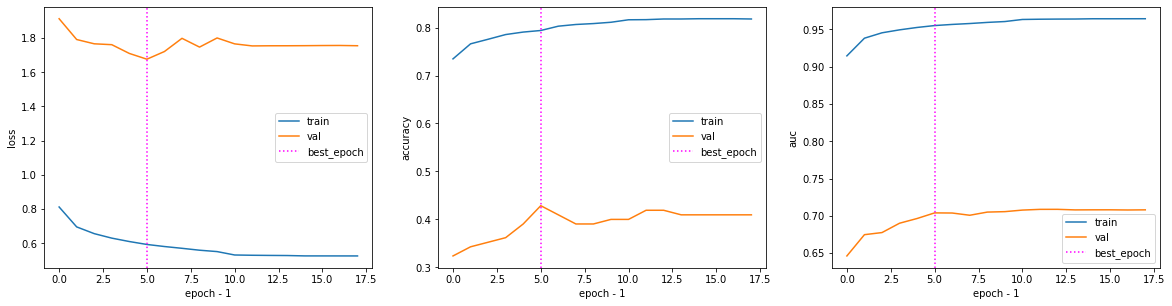

In [142]:
fig, axes = plt.subplots(1,3, figsize=(20, 4.8))

n_epoch = len(history.history['loss'])
xticks, xticksloc = range(1, n_epoch+1), range(n_epoch)
best_epoch = n_epoch - 12 - 1

for ax, to_plot in zip(axes, ['loss', 'accuracy', 'auc']):
    ax.plot(history.history[to_plot], label='train')
    ax.plot(history.history[f'val_{to_plot}'], label='val')
    ax.axvline(best_epoch, ls=':', c='magenta', label='best_epoch')
    ax.set_xlabel('epoch - 1')
    ax.set_ylabel(to_plot)
    ax.legend()

plt.show()

In [143]:
print(classification_report([np.argmax(i) + 1 for i in y_train], np.argmax(model.predict(X_train), axis=1) + 1))

              precision    recall  f1-score   support

           1       0.81      0.58      0.68       256
           2       1.00      0.20      0.34        64
           3       1.00      0.13      0.23       106
           4       0.51      0.30      0.38       515
           5       0.83      0.96      0.89      2727

    accuracy                           0.80      3668
   macro avg       0.83      0.43      0.50      3668
weighted avg       0.79      0.80      0.77      3668



In [144]:
print(classification_report([np.argmax(i) + 1 for i in y_val], np.argmax(model.predict(X_val), axis=1) + 1))

              precision    recall  f1-score   support

           1       0.62      0.50      0.56        20
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        17
           4       0.36      0.22      0.27        23
           5       0.40      1.00      0.57        30

    accuracy                           0.43       105
   macro avg       0.28      0.34      0.28       105
weighted avg       0.31      0.43      0.33       105



## Word2Vec Visualization

### Pre-Visualization Phase

In [145]:
def sentiment(pos_neg_val):
    if pos_neg_val >= 0:
        z = 'Positive'
    else:
        z = 'Negative'
    return z

df_corpus = pd.DataFrame({
    'word':list(corpus),
    'polarity':[pos_neg_ratios[w] for w in corpus],
    'sentiment':[sentiment(pos_neg_ratios[w]) for w in corpus],
    'is_stopword':[nlp(i)[0].is_stop for i in corpus],
#     'pos_':[nlp(i)[0].pos_ for i in corpus]
})

df_corpus.head()

,word,polarity,sentiment,is_stopword
0,able,-2.127728,Negative,False
1,absolutely,0.140441,Positive,False
2,accessories,-1.306127,Negative,False
3,actually,0.322166,Positive,False
4,adapter,-2.246693,Negative,False


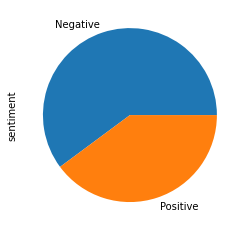

In [146]:
df_corpus['sentiment'].value_counts().plot.pie()
plt.show()

In [147]:
model.weights[0].numpy().shape

(522, 16)

In [148]:
def plot_word_vector(points, polarity_cutoff=0, col_mask='sentiment', colors=['red', 'green'], title=''):
    if title != '':
        title = f'{title} (polarity cutoff = {polarity_cutoff:.2f})'
    
    fig = go.Figure()
    for mask_val, c in zip(np.unique(df_corpus[col_mask]), colors):
        mask = (df_corpus[col_mask] == mask_val) & (abs(df_corpus['polarity']) >= polarity_cutoff)
        p = points[mask]
        n = mask_val
        t = df_corpus.loc[mask, 'word']
        fig.add_trace(
            go.Scatter(
                x=p[:, 0],
                y=p[:, 1],
                marker_color=c,
                mode='markers',
                name=n,
                text=t
            )
        )
    fig.update_layout(showlegend=False, title_text=title, title_x=0.5)
    fig.show()

### Visualization using T-SNE

In [149]:
tsne_scatter = TSNE(n_components=2, random_state=9).fit_transform(model.weights[0].numpy())

In [150]:
plot_word_vector(tsne_scatter, title="vector T-SNE for most polarized words")

In [151]:
plot_word_vector(tsne_scatter, 1., title="vector T-SNE for most polarized words")

### Visualization using PCA

In [152]:
pca_scatter = PCA(n_components=2, random_state=9).fit_transform(model.weights[0].numpy())

In [153]:
plot_word_vector(pca_scatter, title="vector PCA for most polarized words")

In [154]:
plot_word_vector(pca_scatter, 1., title="vector PCA for most polarized words")

### Visualization using UMAP

In [178]:
umap_scatter = UMAP(n_components=2, random_state=9).fit_transform(model.weights[0].numpy())

In [179]:
plot_word_vector(umap_scatter, title="vector UMAP for most polarized words")

In [157]:
plot_word_vector(umap_scatter, 1., title="vector UMAP for most polarized words")

## Most Similar Words

### Using Euclidian Distance

In [158]:
def get_closest_words(focus):
    closest = Counter()
    weights = model.weights[0].numpy()
    x = weights[word2idx[focus]]
    for word in corpus:
        y = weights[word2idx[word]]
        ## euclidian distance
        closest[word] = np.sqrt(np.sum((x - y) ** 2))
    return closest.most_common()[::-1]

In [159]:
get_closest_words('superb')

[('superb', 0.0),
 ('happy', 0.027067615),
 ('perfect', 0.03554185),
 ('love', 0.075075366),
 ('loved', 0.09927632),
 ('deal', 0.10759057),
 ('super', 0.11642317),
 ('life', 0.12082942),
 ('fantastic', 0.122475445),
 ('ios', 0.12594569),
 ('satisfied', 0.12624854),
 ('worth', 0.12659168),
 ('performance', 0.13050391),
 ('budget', 0.13057034),
 ('value', 0.13091277),
 ('thanks', 0.13206862),
 ('wonderful', 0.13209265),
 ('reader', 0.13519068),
 ('thank', 0.13747181),
 ('u', 0.14276737),
 ('sale', 0.14352782),
 ('beautiful', 0.14603382),
 ('loving', 0.14782557),
 ('x', 0.15313998),
 ('smooth', 0.15378262),
 ('review', 0.15395531),
 ('far', 0.15837687),
 ('bit', 0.15966415),
 ('delivery', 0.161058),
 ('try', 0.1614036),
 ('difference', 0.16221666),
 ('beast', 0.16234514),
 ('like', 0.16287349),
 ('thing', 0.1640262),
 ('enjoying', 0.16417958),
 ('packaging', 0.16461137),
 ('lag', 0.16559382),
 ('better', 0.16743478),
 ('package', 0.1677564),
 ('gb', 0.16858804),
 ('word', 0.1701037),
 ('n

In [160]:
get_closest_words('worst')

[('worst', 0.0),
 ('defective', 0.13936858),
 ('return', 0.15753734),
 ('bad', 0.2078077),
 ('service', 0.2545904),
 ('problem', 0.25507903),
 ('network', 0.2578136),
 ('store', 0.27536386),
 ('disappointed', 0.27977198),
 ('faulty', 0.28013542),
 ('box', 0.28019613),
 ('today', 0.2818455),
 ('received', 0.29517308),
 ('center', 0.30114293),
 ('buy', 0.3021801),
 ('defect', 0.3031025),
 ('disappointing', 0.30415785),
 ('replace', 0.31176198),
 ('hanging', 0.31759593),
 ('waste', 0.318078),
 ('item', 0.3180782),
 ('stopped', 0.3205493),
 ('fake', 0.32237324),
 ('gets', 0.32426172),
 ('started', 0.32730475),
 ('customer', 0.3276774),
 ('old', 0.3283143),
 ('work', 0.32856074),
 ('phone', 0.32930753),
 ('month', 0.32965368),
 ('sound', 0.33260825),
 ('pathetic', 0.33337897),
 ('charging', 0.3335257),
 ('able', 0.33552003),
 ('damaged', 0.33689705),
 ('voice', 0.340022),
 ('mobile', 0.3406708),
 ('option', 0.3451837),
 ('completely', 0.34571424),
 ('mode', 0.34615365),
 ('hang', 0.34652564

In [161]:
get_closest_words('camera')

[('camera', 0.0),
 ('fingerprint', 0.0518619),
 ('bought', 0.071820095),
 ('earphones', 0.07182824),
 ('little', 0.0729912),
 ('pictures', 0.07522111),
 ('expensive', 0.075336784),
 ('powerful', 0.082264),
 ('compare', 0.08476749),
 ('red', 0.08547111),
 ('pubg', 0.08737282),
 ('display', 0.08895906),
 ('buttery', 0.088968106),
 ('d', 0.090955675),
 ('fully', 0.09158188),
 ('play', 0.09178838),
 ('came', 0.092343435),
 ('iphones', 0.09535583),
 ('picture', 0.09548097),
 ('etc', 0.09967972),
 ('date', 0.10011891),
 ('unlock', 0.10098066),
 ('future', 0.10208267),
 ('discount', 0.10352489),
 ('glass', 0.105806395),
 ('pro', 0.106338486),
 ('hardly', 0.106631406),
 ('use', 0.107177675),
 ('worthy', 0.10802807),
 ('devices', 0.109890535),
 ('ordered', 0.11086662),
 ('purchasing', 0.11127144),
 ('m', 0.11251029),
 ('clarity', 0.11332553),
 ('spend', 0.11418834),
 ('need', 0.11487303),
 ('colours', 0.11575111),
 ('liked', 0.11575801),
 ('personally', 0.11623637),
 ('hours', 0.11678359),
 ('l

In [162]:
get_closest_words('amazon')

[('amazon', 0.0),
 ('buy', 0.08391668),
 ('customer', 0.10211947),
 ('issue', 0.11263497),
 ('lot', 0.1171525),
 ('seller', 0.11949347),
 ('wifi', 0.125978),
 ('n', 0.12609555),
 ('photo', 0.12780535),
 ('replacement', 0.12919863),
 ('care', 0.13010098),
 ('able', 0.13068028),
 ('high', 0.13098584),
 ('purchase', 0.13533178),
 ('phone', 0.13695222),
 ('sim', 0.13705578),
 ('faulty', 0.13747048),
 ('new', 0.1378793),
 ('told', 0.13842186),
 ('going', 0.13931751),
 ('calls', 0.14024998),
 ('hanging', 0.14086592),
 ('hold', 0.14427073),
 ('stopped', 0.1467164),
 ('months', 0.14813669),
 ('sold', 0.15083624),
 ('provide', 0.15124163),
 ('lower', 0.15130767),
 ('interface', 0.15155172),
 ('extremely', 0.15171708),
 ('month', 0.15172173),
 ('build', 0.15176614),
 ('gud', 0.15263282),
 ('center', 0.15433678),
 ('totally', 0.15444502),
 ('finger', 0.15495197),
 ('doubt', 0.15684623),
 ('received', 0.15722892),
 ('oneplus', 0.15727592),
 ('cut', 0.15740791),
 ('original', 0.1579793),
 ('power',

### Using Cosine Similarity

In [163]:
def get_cosine_similarity(focus):
    closest = Counter()
    weights = model.weights[0].numpy()
    x = weights[word2idx[focus]]
    for word in corpus:
        y = weights[word2idx[word]]
        ## cosine similarity
        closest[word] = np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
    return closest.most_common()

In [164]:
get_cosine_similarity('superb')

[('superb', 1.0),
 ('best', 0.999086),
 ('awesome', 0.9967957),
 ('happy', 0.99467593),
 ('deal', 0.99209225),
 ('perfect', 0.9920081),
 ('great', 0.9867404),
 ('gaming', 0.98570436),
 ('nice', 0.98422337),
 ('awsome', 0.9808504),
 ('x', 0.9710091),
 ('smartphone', 0.96933395),
 ('fantastic', 0.96133536),
 ('lag', 0.9605466),
 ('far', 0.9536345),
 ('pros', 0.9535157),
 ('excellent', 0.9522799),
 ('reader', 0.95224136),
 ('human', 0.9518524),
 ('amazing', 0.9514041),
 ('festival', 0.951168),
 ('scanner', 0.9508953),
 ('specs', 0.94988525),
 ('love', 0.9497532),
 ('latest', 0.9448566),
 ('youtube', 0.94449127),
 ('budget', 0.94326466),
 ('retina', 0.9394237),
 ('place', 0.9365213),
 ('job', 0.9301442),
 ('believe', 0.92503715),
 ('difference', 0.9244474),
 ('choice', 0.9221426),
 ('stars', 0.92080915),
 ('affordable', 0.91991514),
 ('satisfied', 0.9100165),
 ('especially', 0.90868837),
 ('wonderful', 0.9052189),
 ('moderate', 0.90389764),
 ('loved', 0.8995683),
 ('processing', 0.897512),

In [165]:
get_cosine_similarity('worst')

[('worst', 1.0000001),
 ('defective', 0.99477035),
 ('center', 0.99319863),
 ('faulty', 0.9797862),
 ('hanging', 0.97712326),
 ('defect', 0.97116476),
 ('return', 0.9636206),
 ('item', 0.9612975),
 ('able', 0.95077777),
 ('network', 0.9479311),
 ('photo', 0.94607836),
 ('today', 0.94513315),
 ('sound', 0.93943393),
 ('completely', 0.93928504),
 ('month', 0.9306292),
 ('se', 0.9289087),
 ('kindly', 0.9285806),
 ('pathetic', 0.92813575),
 ('complete', 0.9232859),
 ('store', 0.9206357),
 ('went', 0.92055124),
 ('feeling', 0.9156025),
 ('purchase', 0.91356194),
 ('replace', 0.9125388),
 ('resolution', 0.904588),
 ('bad', 0.90322363),
 ('selfie', 0.8847413),
 ('waste', 0.8815699),
 ('disappointing', 0.88053507),
 ('data', 0.87793255),
 ('mode', 0.8681332),
 ('stopped', 0.8680312),
 ('charging', 0.8655414),
 ('buy', 0.86444753),
 ('piece', 0.8625521),
 ('fake', 0.8593473),
 ('box', 0.85790706),
 ('service', 0.8578596),
 ('option', 0.85066366),
 ('told', 0.8487508),
 ('india', 0.84794146),
 (

In [166]:
get_cosine_similarity('camera')

[('camera', 0.99999994),
 ('watch', 0.99589366),
 ('cons', 0.9780326),
 ('red', 0.9712353),
 ('pubg', 0.96965516),
 ('purchasing', 0.9693666),
 ('music', 0.9640412),
 ('non', 0.9606132),
 ('personally', 0.95758617),
 ('fingerprint', 0.9551602),
 ('future', 0.9529487),
 ('earphones', 0.9528061),
 ('decent', 0.9512627),
 ('date', 0.9506335),
 ('clarity', 0.9477984),
 ('bought', 0.94513327),
 ('play', 0.9438106),
 ('powerful', 0.93728393),
 ('operating', 0.93136466),
 ('hardly', 0.9296412),
 ('buttery', 0.9281389),
 ('oled', 0.91777307),
 ('pictures', 0.9060195),
 ('thinking', 0.90370387),
 ('processor', 0.8932422),
 ('users', 0.8927233),
 ('little', 0.8920832),
 ('looking', 0.8899268),
 ('compare', 0.88875854),
 ('spend', 0.88700587),
 ('expensive', 0.88476056),
 ('iphones', 0.8826398),
 ('d', 0.8650259),
 ('colours', 0.8614185),
 ('picture', 0.8525239),
 ('gone', 0.8485204),
 ('display', 0.8402405),
 ('came', 0.8335813),
 ('fully', 0.82504153),
 ('extra', 0.8230814),
 ('watching', 0.822

In [167]:
get_cosine_similarity('amazon')

[('amazon', 1.0),
 ('care', 0.97709256),
 ('going', 0.9502242),
 ('high', 0.94092953),
 ('buy', 0.9029303),
 ('gud', 0.8799799),
 ('black', 0.8751382),
 ('provide', 0.8744526),
 ('sim', 0.8614126),
 ('photo', 0.8474976),
 ('customer', 0.84628266),
 ('wifi', 0.83847094),
 ('seller', 0.8339084),
 ('issue', 0.8329079),
 ('sold', 0.8257883),
 ('told', 0.8193914),
 ('lot', 0.8191138),
 ('interface', 0.8140891),
 ('build', 0.812692),
 ('n', 0.78675914),
 ('running', 0.785797),
 ('cut', 0.7841819),
 ('true', 0.77955794),
 ('replacement', 0.7779761),
 ('new', 0.76861393),
 ('calls', 0.75391096),
 ('purchase', 0.74222004),
 ('able', 0.7379071),
 ('feeling', 0.73461914),
 ('phone', 0.7316982),
 ('online', 0.72768176),
 ('end', 0.7266865),
 ('faulty', 0.723456),
 ('lower', 0.7178678),
 ('received', 0.71606284),
 ('selling', 0.7141593),
 ('extremely', 0.71135247),
 ('instead', 0.70355016),
 ('defective', 0.7024056),
 ('months', 0.68565756),
 ('hanging', 0.6791626),
 ('resolution', 0.6727797),
 ('s

### Clustering

In [ ]:
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN